# Implementation, Testing and Evaluation of Self- and Cross-Consistency in RAG

#### Notebook Outline
1. Imports and Configurations
2. Creation of Vector Database
3. Querying the Vector Database
4. Output of RAG Experiments
5. Evaluations

This notebook uses functions from the Baseline RAG .ipynb file and adapts these.

### 1. Imports and Configurations

Imports

In [1]:
# === Standard Library Imports ===
import json
import os
import sys
import time
from urllib.request import urlopen
from typing import List, Optional

# === Scientific and Visualization Libraries ===
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from sklearn.metrics.pairwise import cosine_similarity

# === Environment Management ===
from dotenv import load_dotenv

# === Language Detection ===
from langdetect import detect

# === Hugging Face and Transformers ===
from transformers import pipeline 
from huggingface_hub import login

# === LangChain Core and Extensions ===
from langchain.embeddings import OpenAIEmbeddings

# === OpenAI and Other LLM APIs ===
import openai
from openai import OpenAI
from together import Together
import google.generativeai as gemini
from google.generativeai.types import GenerationConfig

# === Project Root Configuration ===
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# === Custom Project Modules ===
from ipynb_notebooks.single_stage_enhancements.rankGPT_rerank import rankgpt_rerank

from ipynb_notebooks.baseline.rag_utils.baseline_rag import (
    load_vector_database,
    retrieve_documents,
    generate_answer,
)

from ipynb_notebooks.evaluation_datasets.retrieval_eval.eval_vector_dataset_generator import generate_evalset
from ipynb_notebooks.evaluation_datasets.retrieval_eval.retrieval_metrics import run_retrieval_evaluation
from ipynb_notebooks.evaluation_datasets.generation_eval.generation_metrics import run_generation_evaluation


c:\Users\jonas\Documents\LEGAL-RAG\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jonas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jonas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\jonas\Documents\LEGAL-RAG\ipynb_notebooks\evaluation_datasets\generation_eval\generation_metrics.py:56: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead.

Configurations

In [2]:
# Load environment variables. Assumes that the project directory contains a .env file with API keys
load_dotenv()

# Set the OpenAI API key from the environment variables
# Make sure to update "OPENAI_API_KEY" to match the variable name in your .env file
openai.api_key = os.environ['OPENAI_API_KEY']
client = OpenAI(api_key=openai.api_key)
embedding_model = OpenAIEmbeddings()

# Configure Google Gemini API
gemini_api_key = os.getenv("GEMINI_API_KEY")
gemini.configure(api_key=gemini_api_key)

# Configuration of HuggingFace API
hugging_face_api_key=os.getenv("HUGGING_FACE_API_KEY")
login(token=hugging_face_api_key)

# Configure Together API for model calls
together_api_key = os.getenv("TOGETHER_API_KEY")
os.environ["TOGETHER_API_KEY"] = together_api_key
together_client = Together()

# Configuration of cohere API
cohere_api_key = os.getenv("COHERE_API_KEY")

# Define constants for paths
DATA_PATH = "../../data/laws_and_ordinances.json"  # Directory containing the url to the law and ordinance documents
DATA_PATH_SHORT_VERSION = "../../data/laws_and_ordinances_short_version.json" # Directory containing a subset of all urls for testing purposes
CHROMA_PATH = "chroma_dbs/chroma"  # Directory to save the Chroma vector store

### 2. Creation of Vector Databases

**Why Creating Separate Chroma Databases for Each Retrieval Process Is Not Necessary**

In contrast to chunking experiments, evaluating different retrieval strategies does not require generating separate Chroma vector databases. This is because all strategies operate over the same underlying document corpus and embeddings. Retrieval processes such as iterative, recursive or adaptive approaches differ only in how they search the embedded documents—not in how the documents are chunked or stored.

As long as the Chroma DB is generated using a consistent chunking strategy and embedding model, it provides a shared semantic space that is sufficient for fair comparison across retrieval methods. Creating separate vector stores per strategy would introduce unnecessary redundancy and would not improve the validity of the evaluation.

In [3]:
chroma_db_self_and_cross_consistency = "../chroma_dbs/chroma_chunksize1024_overlap128_c800ccc6_self_cross_consistency"

### 3. Post-Retrieval Optimization: Self and Cross Consistency

#### 3.1 Self-Consistency

In [4]:
def select_most_consistent_answer(answers):
    embeddings = embedding_model.embed_documents(texts=answers)
    similarity_matrix = cosine_similarity(embeddings)
    avg_sim = similarity_matrix.mean(axis=1)
    best_index = int(np.argmax(avg_sim))
    return answers[best_index], avg_sim, similarity_matrix

In [5]:
def plot_answer_similarity_heatmap(
    answers: list[str],
    labels: list[str] = None,
    similarity_matrix: Optional[np.ndarray] = None,
    avg_similarities: Optional[np.ndarray] = None,
    title: str = "LLM Answer Similarity"
):

    if similarity_matrix is None:
        from sentence_transformers import SentenceTransformer
        from sklearn.metrics.pairwise import cosine_similarity
        model = SentenceTransformer("all-MiniLM-L6-v2")
        embeddings = model.encode(answers)
        similarity_matrix = cosine_similarity(embeddings)

    if labels is None:
        labels = [f"Model {i+1}" for i in range(len(answers))]

    if avg_similarities is not None:
        annotated_labels = [
            f"{name}\nØ={avg:.4f}" for name, avg in zip(labels, avg_similarities)
        ]
    else:
        annotated_labels = labels

    # Plot
    plt.figure(figsize=(9, 7))
    sns.heatmap(
        similarity_matrix,
        annot=True,
        fmt=".4f",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=annotated_labels,
        square=True,
        cbar=True
    )
    plt.title(title)
    plt.xlabel("LLM Answer")
    plt.ylabel("LLM Answer")
    plt.tight_layout()
    plt.show()

    return similarity_matrix

In [6]:
def rag_pipeline_self_consistency(query, database, model_name="gpt-4o-mini", n=5, temperature=0.7, heatmap: bool = False):
    """
    RAG-Pipeline mit eingebauter Self-Consistency über n generierte Antworten.
    """
    results_tuple = retrieve_documents(query, db=database)
    
    results = [result for result, _ in results_tuple]

    sources = [doc.metadata.get("source") for doc in results]
    retrieved_chunk_contexts = [doc.page_content for doc in results]
    retrieved_chunk_ids = [doc.metadata.get("chunk_id") for doc in results]
    retrieved_chunk_indices = [doc.metadata.get("chunk_index") for doc in results]

    answers = []
    for i in range(n):
        try:
            answer = generate_answer(results, query, model_name=model_name, temperature=temperature)
            answers.append(answer)
        except Exception as e:
            print(f"Fehler bei Generation {i+1}: {e}")
            answers.append("")

        time.sleep(0.5) 

    final_answer, similarities, similarity_matrix = select_most_consistent_answer(answers)
    
    if heatmap:

        print("\n--- Self-Consistency Antworten ---")
        for i, a in enumerate(answers):
            print(f"[{i+1}] ({similarities[i]:.4f}): {a}")

        print("\n--- Finale Antwort ---")
        print(final_answer)
        
        answer_labels = [f"Answer {i}" for i in range(1, n + 1)]
        plot_answer_similarity_heatmap(answers=answers, labels=answer_labels, similarity_matrix=similarity_matrix, avg_similarities=similarities)

    return final_answer, sources, retrieved_chunk_contexts, retrieved_chunk_ids, retrieved_chunk_indices

c:\Users\jonas\Documents\LEGAL-RAG\ipynb_notebooks\baseline\rag_utils\baseline_rag.py:303: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(persist_directory=chroma_path, embedding_function=embedding_function)
c:\Users\jonas\Documents\LEGAL-RAG\ipynb_notebooks\baseline\rag_utils\baseline_rag.py:339: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response_text = model.predict(prompt)



--- Self-Consistency Antworten ---
[1] (0.9895): § 1 des Elektromobilitätsgesetzes (EmoG) definiert das Ziel des Gesetzes, welches die Förderung einer nachhaltigen und treibhausgasneutralen Stromversorgung in Deutschland zum Inhalt hat. Der Anwendungsbereich umfasst Maßnahmen zur Erhöhung des Anteils von Strom aus erneuerbaren Energien am Bruttostromverbrauch. Bis 2030 soll dieser Anteil auf mindestens 80 Prozent gesteigert werden. Des Weiteren wird ein stetiger, kosteneffizienter und umweltverträglicher Ausbau der erneuerbaren Energien angestrebt, um die Klimaziele zu erreichen. Dies schließt auch die Notwendigkeit ein, dass der Ausbau netzverträglich erfolgt.
[2] (0.9879): § 1 des Elektromobilitätsgesetzes (EmoG) legt die Zielsetzung des Gesetzes fest, die auf die Transformation zu einer nachhaltigen und treibhausgasneutralen Stromversorgung abzielt. Der Anwendungsbereich umfasst insbesondere die Erhöhung des Anteils an aus erneuerbaren Energien erzeugtem Strom im Bruttostromverbrau

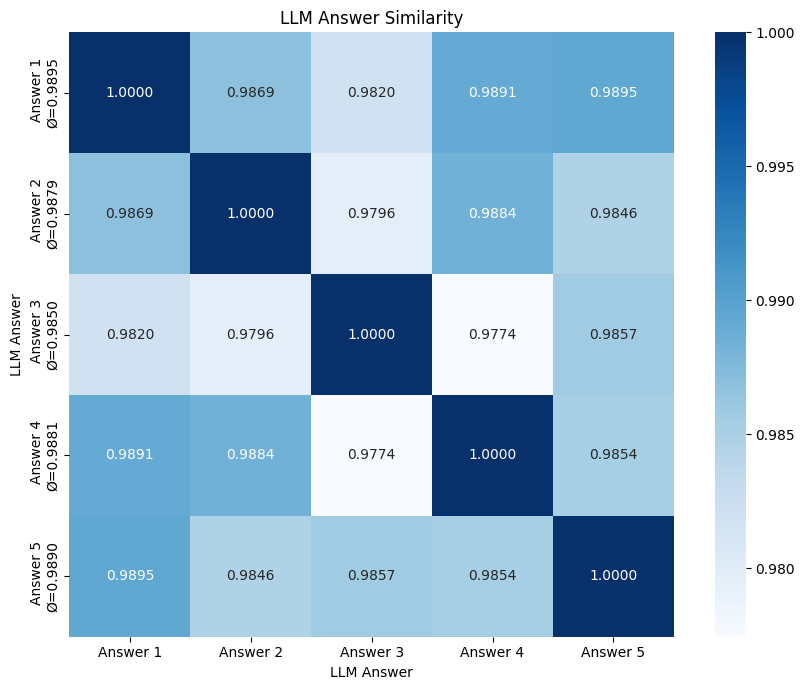

In [7]:
query = "Welchen Anwendungsbereich umfasst §1 des Elektromobilitätsgesetzes - (EmoG)?"
database = load_vector_database(chroma_path=chroma_db_self_and_cross_consistency)
model_name = "gpt-4o-mini"  # or any other supported model

response, sources, retrieved_chunk_contexts, retrieved_chunk_ids, retrieved_chunk_indices = rag_pipeline_self_consistency(query=query, 
                                                                                                                        database=database,
                                                                                                                        heatmap=True)

#### 3.2 Cross-Consistency

In [8]:
def generate_with_gpt(query: str, docs: List[str], model_name="gpt-4o-mini", temperature=0.2):
    
    response = generate_answer(docs, query, model_name=model_name, temperature=temperature)
    
    return response

In [9]:
generation_config = GenerationConfig(
    temperature=0.2,    
    top_p=1.0,
    top_k=40,
    max_output_tokens=256
)


def generate_with_gemini(query: str, docs: list[str]) -> str:
    
    docs_content = [doc.page_content for doc in docs]
    
    context = "\n".join(docs_content)
    prompt = f"""
                Du bist ein juristisch präziser Assistent. Antworte vollständig und korrekt auf folgende Frage auf Basis des Kontexts.

                Kontext:
                {context}

                Frage:
                {query}
                """
    model = gemini.GenerativeModel(model_name = "gemini-1.5-flash-002", generation_config=generation_config)
    response = model.generate_content(prompt)
    return response.text.strip()

In [10]:
def generate_with_together(query: str, docs: list[str], provider: str = "meta") -> str:
    
    if provider=="meta":
        model = "meta-llama/Llama-3.3-70B-Instruct-Turbo-Free"
    elif provider=="deepseek":
        model = "deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free"
    
    context = "\n".join([doc.page_content for doc in docs])

    prompt = f"""
    Du bist ein juristisch präziser Assistent. Antworte vollständig und korrekt auf folgende Frage auf Basis des Kontexts.
    
    Kontext:
    {context}
    
    Frage:
    {query}
    """

    try:

        response = together_client.chat.completions.create(
            model=model,
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=0.2,
            max_tokens=200,
        )

        return response.choices[0].message.content.strip()

    except Exception as e:
        print(f"❌ Fehler bei Together API: {e}")
        return "Fehler bei der Antwortgenerierung durch Together."


In [11]:
flan_t5_large_pipe = pipeline("text2text-generation", model="google/flan-t5-large")

def generate_with_flan_t5_large(query: str, docs: list, max_new_tokens: int = 200) -> str:
 
    if not docs:
        return "❌ No documents retrieved."

    # Use only the first chunk to avoid token limit issues
    context = docs[0].page_content

    prompt = (
        "Answer the following legal question based on the provided context. "
        "Give a detailed answer in 2–4 sentences.\n\n"
        f"Context:\n{context}\n\n"
        f"Question:\n{query}"
        "Answer in the language of the question"
    )

    try:
        result = flan_t5_large_pipe(prompt, max_new_tokens=max_new_tokens, clean_up_tokenization_spaces=True)
        return result[0]['generated_text'].strip()
    except Exception as e:
        print(f"❌ Flan-T5-Large Error: {e}")
        return "Flan-T5-Large konnte keine Antwort generieren."


Device set to use cpu


In [12]:
def rag_pipeline_cross_consistency(query, database, heatmap: bool = False):
    
    results_tuple = retrieve_documents(query, db=database)
    results = [result for result, _ in results_tuple]

    sources = [doc.metadata.get("source") for doc in results]
    retrieved_chunk_contexts = [doc.page_content for doc in results]
    retrieved_chunk_ids = [doc.metadata.get("chunk_id") for doc in results]
    retrieved_chunk_indices = [doc.metadata.get("chunk_index") for doc in results]

    models = [
        ("GPT-4o-mini", generate_with_gpt),
        ("Gemini-1.5-flash-002", generate_with_gemini),
        ("Llama-3.3-70B-Instruct", lambda q, r: generate_with_together(q, r, provider="meta")),
        ("DeepSeek-R1-Distill-Llama-70B", lambda q, r: generate_with_together(q, r, provider="deepseek")),
        ("Flan-T5-Large", generate_with_flan_t5_large)
    ]

    answers = []
    model_names = []

    for name, func in models:
        try:
            answer = func(query, results)
            answers.append(answer)
        except Exception as e:
            print(f"❌ Error in {name}: {e}")
            answers.append("")
        model_names.append(name)
        time.sleep(0.5) 

    final_answer, similarities, similarity_matrix = select_most_consistent_answer(answers)
    
    if heatmap:
        print("\n--- Cross-Consistency Answers ---")
        for i, (name, answer) in enumerate(zip(model_names, answers)):
            sim_str = f"({similarities[i]:.4f})" if similarities[i] is not None else ""
            print(f"[{i+1}] {name} {sim_str}: {answer}")

        print("\n--- Final Answer ---")
        print(final_answer)
        
        plot_answer_similarity_heatmap(answers=answers, labels=model_names, similarity_matrix=similarity_matrix, avg_similarities=similarities)

    return final_answer, sources, retrieved_chunk_contexts, retrieved_chunk_ids, retrieved_chunk_indices

Token indices sequence length is longer than the specified maximum sequence length for this model (1141 > 512). Running this sequence through the model will result in indexing errors



--- Cross-Consistency Answers ---
[1] GPT-4o-mini (0.9093): § 1 des Elektromobilitätsgesetzes (EmoG) legt das Ziel des Gesetzes fest, das insbesondere den Klima- und Umweltschutz fördert. Es strebt eine nachhaltige und treibhausgasneutrale Stromversorgung an, die vollständig auf erneuerbaren Energien basiert. Der Anwendungsbereich umfasst die Verpflichtung, den Anteil des aus erneuerbaren Energien erzeugten Stroms am Bruttostromverbrauch in Deutschland bis 2030 auf mindestens 80 Prozent zu steigern. Zudem wird der Ausbau der erneuerbaren Energien als stetig, kosteneffizient, umweltverträglich und netzverträglich definiert. Diese Bestimmungen sind entscheidend für die Transformation des Energiesystems in Deutschland und unterstützen die Erreichung der Klimaziele.
[2] Gemini-1.5-flash-002 (0.9001): Die bereitgestellte Textmenge enthält keinen Gesetzestext zum Elektromobilitätsgesetz (EmoG).  Daher kann die Frage nach dem Anwendungsbereich von §1 des EmoG auf Basis des gegebenen Kontexte

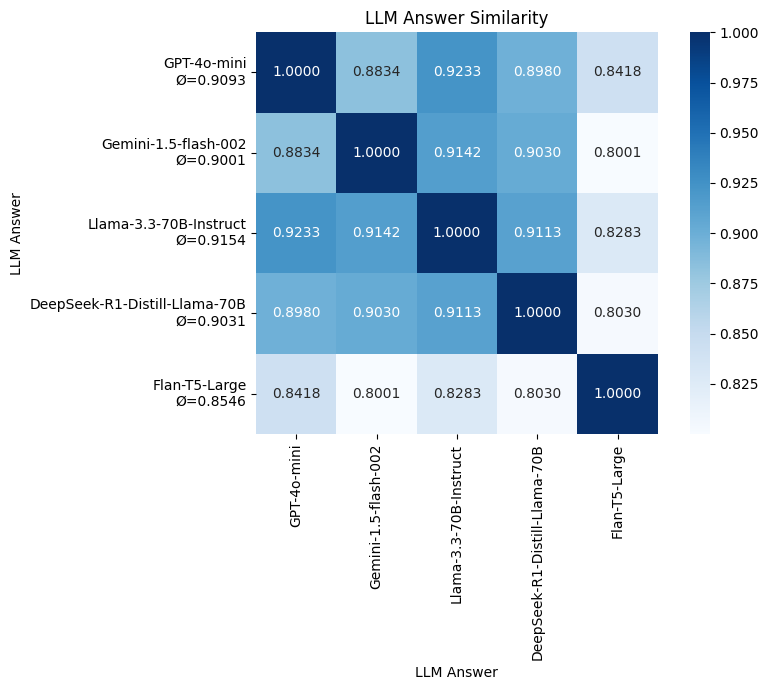

In [13]:
query = "Welchen Anwendungsbereich umfasst §1 des Elektromobilitätsgesetzes - (EmoG)?"
database = load_vector_database(chroma_path=chroma_db_self_and_cross_consistency)
model_name = "gpt-4o-mini"  # or any other supported model

response, sources, retrieved_chunk_contexts, retrieved_chunk_ids, retrieved_chunk_indices = rag_pipeline_cross_consistency(query=query, 
                                                                                                                        database=database,
                                                                                                                        heatmap=True)

### 4. Evaluations

#### 4.1 Preparing the Evaluation Dataset

Since no new Chroma DB had to be created, the evaluation data set from the RAG baseline can also be reused. The data set was copied and renamed to ensure completeness.

In [14]:
eval_dataset_self_and_cross_consistency = "eval_datasets/6_self_cross_consistency/artificial_evaluation_dataset_for_chroma_chunksize1024_overlap128_c800ccc6_self_cross_consistency.json"

#### 4.2 Enrich Evaluation Datasets with Responses

In [15]:
def enrich_eval_dataset_with_rag_responses_consistency(
    eval_dataset: str,
    chroma_path: str,
    consistency_type: str = "self",  # "self" oder "cross"
    model_name: str = "gpt-4o-mini"
):
    
    db = load_vector_database(chroma_path)

    with open(eval_dataset, "r", encoding="utf-8") as f:
        eval_dataset_json = json.load(f)

    enriched_dataset = []

    for i, entry in enumerate(tqdm(eval_dataset_json, desc="Generating consistent RAG responses")):
        query = entry["query"]

        # Choose pipeline
        if consistency_type == "self":
            response, _, retrieved_chunk_contexts, retrieved_chunk_ids, retrieved_chunk_indices = rag_pipeline_self_consistency(
                query=query,
                database=db,
                model_name=model_name,
                n=5  # Amount of samples for self-consistency
            )
        elif consistency_type == "cross":
            response, _, retrieved_chunk_contexts, retrieved_chunk_ids, retrieved_chunk_indices = rag_pipeline_cross_consistency(
                query=query,
                database=db
            )
        else:
            raise ValueError("consistency_type must be either 'self' or 'cross'")

        # Enrich entry
        entry["generated_response"] = response
        entry["retrieved_chunk_contexts"] = retrieved_chunk_contexts
        entry["retrieved_chunk_ids"] = retrieved_chunk_ids
        entry["retrieved_chunk_indices"] = retrieved_chunk_indices

        enriched_dataset.append(entry)

    # Dateinamen-Logik
    filename = eval_dataset.split("/")[-1].replace(".json", "")
    output_path = f"eval_datasets/{filename}_{consistency_type}_consistency_enriched.json"

    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(enriched_dataset, f, indent=2, ensure_ascii=False)

    return output_path


In [16]:
enriched_datasets = []

# Self-Consistency 
enriched_datasets.append(enrich_eval_dataset_with_rag_responses_consistency(
        eval_dataset=eval_dataset_self_and_cross_consistency,
        chroma_path=chroma_db_self_and_cross_consistency,
        consistency_type= "self",
        model_name="gpt-4o-mini"
    ))

Generating consistent RAG responses: 100%|██████████| 50/50 [18:23<00:00, 22.07s/it]


In [17]:
# Cross-Consistency 
enriched_datasets.append(enrich_eval_dataset_with_rag_responses_consistency(
        eval_dataset=eval_dataset_self_and_cross_consistency,
        chroma_path=chroma_db_self_and_cross_consistency,
        consistency_type= "cross",
        model_name="gpt-4o-mini"
    ))

Generating consistent RAG responses:   4%|▍         | 2/50 [03:08<1:17:19, 96.65s/it]

❌ Fehler bei Together API: Error code: 422 - {"message": "Input validation error: `inputs` tokens + `max_new_tokens` must be <= 8193. Given: 8039 `inputs` tokens and 200 `max_new_tokens`", "type_": "invalid_request_error"}
❌ Fehler bei Together API: Error code: 422 - {"message": "Input validation error: `inputs` tokens + `max_new_tokens` must be <= 8193. Given: 8010 `inputs` tokens and 200 `max_new_tokens`", "type_": "invalid_request_error"}


Generating consistent RAG responses:  28%|██▊       | 14/50 [21:56<59:35, 99.31s/it]  

❌ Fehler bei Together API: Error code: 422 - {"message": "Input validation error: `inputs` tokens + `max_new_tokens` must be <= 8193. Given: 8303 `inputs` tokens and 200 `max_new_tokens`", "type_": "invalid_request_error"}
❌ Fehler bei Together API: Error code: 422 - {"message": "Input validation error: `inputs` tokens + `max_new_tokens` must be <= 8193. Given: 8274 `inputs` tokens and 200 `max_new_tokens`", "type_": "invalid_request_error"}


Generating consistent RAG responses:  40%|████      | 20/50 [30:58<48:51, 97.71s/it]

❌ Fehler bei Together API: Error code: 422 - {"message": "Input validation error: `inputs` tokens + `max_new_tokens` must be <= 8193. Given: 8101 `inputs` tokens and 200 `max_new_tokens`", "type_": "invalid_request_error"}
❌ Fehler bei Together API: Error code: 422 - {"message": "Input validation error: `inputs` tokens + `max_new_tokens` must be <= 8193. Given: 8072 `inputs` tokens and 200 `max_new_tokens`", "type_": "invalid_request_error"}


Generating consistent RAG responses:  42%|████▏     | 21/50 [31:35<38:24, 79.46s/it]

❌ Fehler bei Together API: Error code: 422 - {"message": "Input validation error: `inputs` tokens + `max_new_tokens` must be <= 8193. Given: 8089 `inputs` tokens and 200 `max_new_tokens`", "type_": "invalid_request_error"}
❌ Fehler bei Together API: Error code: 422 - {"message": "Input validation error: `inputs` tokens + `max_new_tokens` must be <= 8193. Given: 8060 `inputs` tokens and 200 `max_new_tokens`", "type_": "invalid_request_error"}


Generating consistent RAG responses:  70%|███████   | 35/50 [53:18<24:46, 99.07s/it]

❌ Fehler bei Together API: Error code: 422 - {"message": "Input validation error: `inputs` tokens + `max_new_tokens` must be <= 8193. Given: 8289 `inputs` tokens and 200 `max_new_tokens`", "type_": "invalid_request_error"}
❌ Fehler bei Together API: Error code: 422 - {"message": "Input validation error: `inputs` tokens + `max_new_tokens` must be <= 8193. Given: 8260 `inputs` tokens and 200 `max_new_tokens`", "type_": "invalid_request_error"}


Generating consistent RAG responses:  84%|████████▍ | 42/50 [1:02:14<12:08, 91.06s/it]

❌ Fehler bei Together API: Error code: 422 - {"message": "Input validation error: `inputs` tokens + `max_new_tokens` must be <= 8193. Given: 8204 `inputs` tokens and 200 `max_new_tokens`", "type_": "invalid_request_error"}
❌ Fehler bei Together API: Error code: 422 - {"message": "Input validation error: `inputs` tokens + `max_new_tokens` must be <= 8193. Given: 8175 `inputs` tokens and 200 `max_new_tokens`", "type_": "invalid_request_error"}


Generating consistent RAG responses:  88%|████████▊ | 44/50 [1:04:54<08:43, 87.21s/it]

❌ Fehler bei Together API: Error code: 422 - {"message": "Input validation error: `inputs` tokens + `max_new_tokens` must be <= 8193. Given: 8157 `inputs` tokens and 200 `max_new_tokens`", "type_": "invalid_request_error"}
❌ Fehler bei Together API: Error code: 422 - {"message": "Input validation error: `inputs` tokens + `max_new_tokens` must be <= 8193. Given: 8128 `inputs` tokens and 200 `max_new_tokens`", "type_": "invalid_request_error"}


Generating consistent RAG responses:  96%|█████████▌| 48/50 [1:11:44<03:22, 101.07s/it]

❌ Fehler bei Together API: Error code: 422 - {"message": "Input validation error: `inputs` tokens + `max_new_tokens` must be <= 8193. Given: 8020 `inputs` tokens and 200 `max_new_tokens`", "type_": "invalid_request_error"}


Generating consistent RAG responses: 100%|██████████| 50/50 [1:14:59<00:00, 90.00s/it] 


#### 4.3. Evaluate Retrieval & Generation

In [18]:
for index, dataset in enumerate(enriched_datasets): 
    json_filename = dataset.split("/")[-1]
    model_name = f"optimal_post_retrieval_reranking_{index+1}_{json_filename.replace('retrieval_eval_dataset_for_', '').replace('_rag_enriched.json', '')}"  
    print(json_filename)
    print(model_name)

artificial_evaluation_dataset_for_chroma_chunksize1024_overlap128_c800ccc6_self_cross_consistency_self_consistency_enriched.json
optimal_post_retrieval_reranking_1_artificial_evaluation_dataset_for_chroma_chunksize1024_overlap128_c800ccc6_self_cross_consistency_self_consistency_enriched.json
artificial_evaluation_dataset_for_chroma_chunksize1024_overlap128_c800ccc6_self_cross_consistency_cross_consistency_enriched.json
optimal_post_retrieval_reranking_2_artificial_evaluation_dataset_for_chroma_chunksize1024_overlap128_c800ccc6_self_cross_consistency_cross_consistency_enriched.json


In [20]:
print(enriched_datasets)

['eval_datasets/artificial_evaluation_dataset_for_chroma_chunksize1024_overlap128_c800ccc6_self_cross_consistency_self_consistency_enriched.json', 'eval_datasets/artificial_evaluation_dataset_for_chroma_chunksize1024_overlap128_c800ccc6_self_cross_consistency_cross_consistency_enriched.json']


In [ ]:
enriched_datasets = [
    'eval_datasets/6_self_cross_consistency/artificial_evaluation_dataset_for_chroma_chunksize1024_overlap128_c800ccc6_self_consistency_enriched.json',
    'eval_datasets/6_self_cross_consistency/artificial_evaluation_dataset_for_chroma_chunksize1024_overlap128_c800ccc6_cross_consistency_enriched.json'
]


In [22]:
evaluation_results_optimal_chunking = {}
generation_results_optimal_chunking = {}

for index, dataset in enumerate(enriched_datasets):
    json_filename = dataset.split("/")[-1]
    model_name = f"optimal_post_retrieval_reranking_{index+1}_{json_filename.replace('retrieval_eval_dataset_for_', '').replace('_rag_enriched.json', '')}"  


    json_filename = f"6_self_cross_consistency/{dataset.split('/')[-1]}"
    model_name = f"optimal_self_cross_consistency_{index+1}_{json_filename.replace('6_self_cross_consistency/artificial_evaluation_dataset_for_chroma_chunksize1024_overlap128_c800ccc6_', '').replace('_rag_enriched.json', '')}"  
    

    print(f"\nEvaluating {model_name} using dataset {json_filename}...")

    retrieval_result = run_retrieval_evaluation(
        json_filename=json_filename,
        model_name=model_name
    )

    generation_result = run_generation_evaluation(
        json_filename=json_filename,
        model_name=model_name
    )

    evaluation_results_optimal_chunking[model_name] = retrieval_result
    generation_results_optimal_chunking[model_name] = generation_result


Evaluating optimal_self_cross_consistency_1_self_consistency_enriched.json using dataset 6_self_cross_consistency/artificial_evaluation_dataset_for_chroma_chunksize1024_overlap128_c800ccc6_self_consistency_enriched.json...
→ Calculation: Mean Recall@k


100%|██████████| 50/50 [00:00<?, ?it/s]


→ Calculation: Mean Reciprocal Rank


100%|██████████| 50/50 [00:00<00:00, 50063.31it/s]


→ Calculation: Mean Average Precision


100%|██████████| 50/50 [00:00<00:00, 50051.36it/s]


→ Calculation: Mean Context Precision Using Ragas with Reference and NonLLM-Based


100%|██████████| 50/50 [00:01<00:00, 44.05it/s]


→ Calculation: Mean Context Recall Using Ragas with NonLLM-Based


100%|██████████| 50/50 [00:01<00:00, 43.01it/s]


→ Calculation: Mean ROUGE Scores (Rouge1, Rouge2, RougeL)


100%|██████████| 50/50 [00:00<00:00, 69.92it/s]


→ Calculation: BERTScore (Precision, Recall, F1)


Preparing BERTScore input: 100%|██████████| 50/50 [00:00<?, ?it/s]


calculating scores...
computing bert embedding.


100%|██████████| 2/2 [00:24<00:00, 12.44s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


done in 25.03 seconds, 2.00 sentences/sec
→ Calculation: Mean BLEU Score


100%|██████████| 50/50 [00:00<00:00, 342.22it/s]


→ Calculation: Mean METEOR Score


100%|██████████| 50/50 [00:05<00:00,  9.56it/s]



Evaluating optimal_self_cross_consistency_2_cross_consistency_enriched.json using dataset 6_self_cross_consistency/artificial_evaluation_dataset_for_chroma_chunksize1024_overlap128_c800ccc6_cross_consistency_enriched.json...
→ Calculation: Mean Recall@k


100%|██████████| 50/50 [00:00<?, ?it/s]


→ Calculation: Mean Reciprocal Rank


100%|██████████| 50/50 [00:00<?, ?it/s]


→ Calculation: Mean Average Precision


100%|██████████| 50/50 [00:00<?, ?it/s]


→ Calculation: Mean Context Precision Using Ragas with Reference and NonLLM-Based


100%|██████████| 50/50 [00:00<00:00, 53.32it/s]


→ Calculation: Mean Context Recall Using Ragas with NonLLM-Based


100%|██████████| 50/50 [00:01<00:00, 49.35it/s]


→ Calculation: Mean ROUGE Scores (Rouge1, Rouge2, RougeL)


100%|██████████| 50/50 [00:00<00:00, 97.55it/s] 


→ Calculation: BERTScore (Precision, Recall, F1)


Preparing BERTScore input: 100%|██████████| 50/50 [00:00<?, ?it/s]


calculating scores...
computing bert embedding.


100%|██████████| 2/2 [00:26<00:00, 13.43s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


done in 26.97 seconds, 1.85 sentences/sec
→ Calculation: Mean BLEU Score


100%|██████████| 50/50 [00:00<00:00, 311.91it/s]


→ Calculation: Mean METEOR Score


100%|██████████| 50/50 [00:00<00:00, 179.48it/s]


In [23]:
from pathlib import Path
import pandas as pd

# Define base folder and file patterns
folder_path = Path("eval_results") / "6_self_cross_consistency"
pattern_retrieval = "optimal_self_cross_consistency*retrieval_evaluation.csv"
pattern_generation = "optimal_self_cross_consistency*generation_evaluation.csv"

# Find matching CSV files
csv_retrieval_files = list(folder_path.glob(pattern_retrieval))
csv_generation_files = list(folder_path.glob(pattern_generation))

print(f"🔍 Found {len(csv_retrieval_files)} retrieval files.")
print(f"🔍 Found {len(csv_generation_files)} generation files.")

# Load and combine retrieval evaluation files
df_retrieval = [pd.read_csv(f) for f in csv_retrieval_files]
df_generation = [pd.read_csv(f) for f in csv_generation_files]

# Concatenate if there is at least one file
if df_retrieval:
    combined_df_retrieval = pd.concat(df_retrieval, ignore_index=True)
    output_path_retrieval = folder_path / "combined_self_cross_consistency_retrieval_evaluation.csv"
    combined_df_retrieval.to_csv(output_path_retrieval, index=False)
    print(f"✅ Retrieval results saved to: {output_path_retrieval}")
else:
    print("⚠️ No retrieval CSV files found.")

if df_generation:
    combined_df_generation = pd.concat(df_generation, ignore_index=True)
    output_path_generation = folder_path / "combined_self_cross_consistency_evaluation.csv"
    combined_df_generation.to_csv(output_path_generation, index=False)
    print(f"✅ Generation results saved to: {output_path_generation}")
else:
    print("⚠️ No generation CSV files found.")


🔍 Found 2 retrieval files.
🔍 Found 2 generation files.
✅ Retrieval results saved to: eval_results\6_self_cross_consistency\combined_self_cross_consistency_retrieval_evaluation.csv
✅ Generation results saved to: eval_results\6_self_cross_consistency\combined_self_cross_consistency_evaluation.csv
